# 01 — Data Exploration (Prices & Indicators)

Este notebook dispara a atualização de dados pela **API** e mostra como visualizar **candles** com **SMA(20/50)** e **ATR(14)**.

> **Pré-requisitos**
> - API rodando em `http://localhost:8000`
> - Pacotes locais: `pandas`, `matplotlib`, `mplfinance`, `requests`, `numpy`, `yfinance`
> - Caso não tenha, instale no seu ambiente local:
> ```bash
> pip install pandas matplotlib mplfinance requests numpy yfinance
> ```


In [49]:
BASE = "http://localhost:8000"  # URL da sua API
TICKER = "PETR4.SA"
START = "2022-01-01"
END   = "2025-09-01"

SMA_FAST = 20
SMA_SLOW = 50
ATR_WIN  = 14

## 1) Disparar atualização de dados/indicadores via API


In [50]:
import requests

payload = {
    "ticker": TICKER,
    "start": START,
    "end": END,
    "sma_fast": SMA_FAST,
    "sma_slow": SMA_SLOW,
    "atr_window": ATR_WIN,
}
r = requests.post(f"{BASE}/data/update", json=payload, timeout=120)
print("Status:", r.status_code)
r.json()


Status: 200


{'symbol_id': 1, 'inserted_prices': 915, 'inserted_indicators': 2664}

## 2) Obter preços para visualização

Como a API não expõe um endpoint de preços, vamos carregar os candles com **yfinance** apenas para visualizar no gráfico local.
Se preferir, você pode buscar direto do banco no futuro.


In [51]:
import pandas as pd
import numpy as np

try:
    import yfinance as yf
except ImportError:
    raise SystemExit("Instale o yfinance com: pip install yfinance")

data = yf.download(TICKER, start=START, end=END)
data.index.name = "date"
data.head()


C:\Users\marcu\AppData\Local\Temp\ipykernel_4992\1684012842.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(TICKER, start=START, end=END)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA
date,,,,,
2022-01-03,10.602619,10.650001,10.398513,10.402157,52704700
2022-01-04,10.642714,10.715608,10.537015,10.628134,51739200
2022-01-05,10.230855,10.668227,10.183473,10.639069,78459800
2022-01-06,10.223565,10.442251,10.147025,10.311040,61163100
2022-01-07,10.270947,10.311039,10.139735,10.245433,47507600


## 3) Calcular indicadores (SMA e ATR) para visualização


In [52]:
# SMA
data["SMA_FAST"] = data["Close"].rolling(SMA_FAST).mean()
data["SMA_SLOW"] = data["Close"].rolling(SMA_SLOW).mean()

# ATR (Wilder, aproximação)
hl = data["High"] - data["Low"]
hc = (data["High"] - data["Close"].shift()).abs()
lc = (data["Low"] - data["Close"].shift()).abs()
tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
data["ATR"] = tr.rolling(ATR_WIN).mean()

data.tail(3)


Price,Close,High,Low,Open,Volume,SMA_FAST,SMA_SLOW,ATR
Ticker,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,PETR4.SA,,,
date,,,,,,,,
2025-08-27,30.66,30.680000,30.360001,30.450001,16349100,30.462054,30.917644,0.596203
2025-08-28,30.93,31.129999,30.709999,30.780001,25802500,30.412757,30.892645,0.490086
2025-08-29,31.10,31.350000,30.850000,30.930000,27713400,30.392983,30.872806,0.490879


## 4) Plotar Candlestick + SMA(20/50) e ATR


In [53]:
import pandas as pd

# Se vier com MultiIndex (ex.: 2 níveis: [price_type, ticker])
if isinstance(data.columns, pd.MultiIndex):
    if len(data.columns.levels) == 2:
        # Caso comum do yfinance: dropar o nível do ticker
        data.columns = data.columns.droplevel(1)
    else:
        # Achatar juntando níveis por "_"
        data.columns = ['_'.join([str(x) for x in col if str(x) != '']) for col in data.columns]

# Garante nomes esperados
data = data.rename(columns={
    'Open':'Open', 'High':'High', 'Low':'Low', 'Close':'Close',
    'Adj Close':'Adj Close', 'Volume':'Volume'
})

print("Colunas após ajuste:", list(data.columns))



Colunas após ajuste: ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_FAST', 'SMA_SLOW', 'ATR']


c:\Users\marcu\Desktop\case-trading-api\trading-api-starter-part1\.venv\Lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


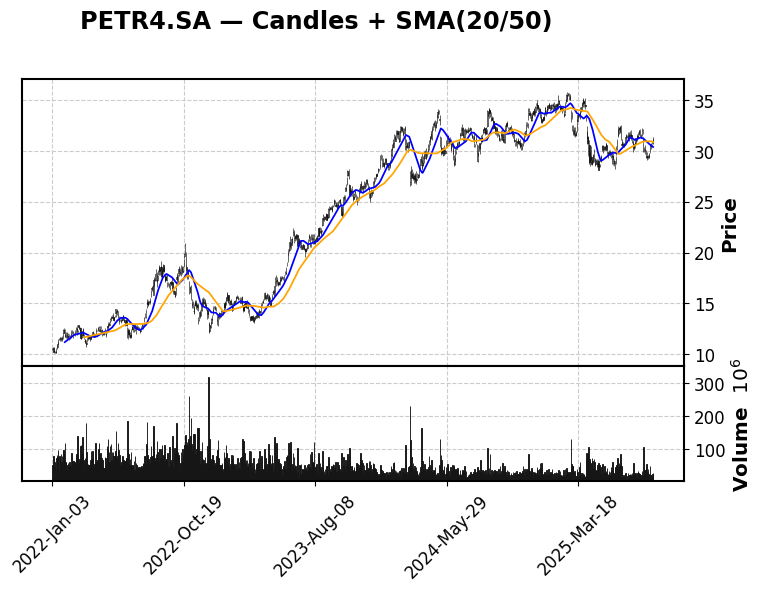

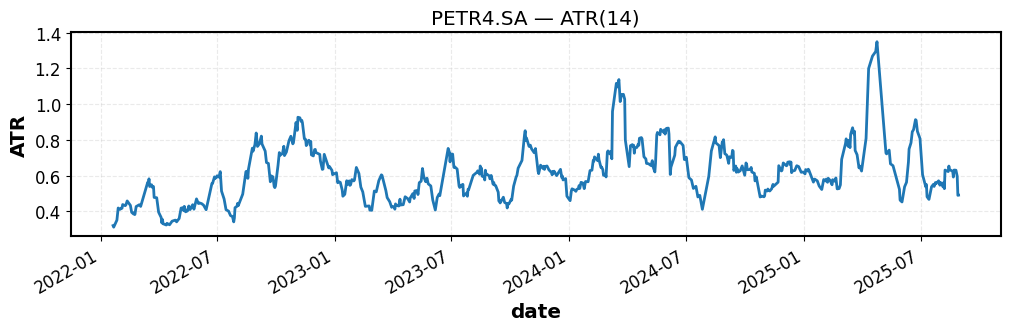

In [54]:
import mplfinance as mpf
import matplotlib.pyplot as plt
import pandas as pd

# --- helpers compactos ---
def flatten_yf(df: pd.DataFrame) -> pd.DataFrame:
    if isinstance(df.columns, pd.MultiIndex):
        # caso comum do yfinance: (col, ticker)
        try:
            df = df.copy()
            df.columns = df.columns.droplevel(1)
        except Exception:
            df = df.copy()
            df.columns = ['_'.join(map(str, c)).strip('_') for c in df.columns]
    return df

def clean_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    cols = [c for c in ['Open','High','Low','Close','Volume'] if c in df.columns]
    df = df[cols].apply(pd.to_numeric, errors='coerce')
    df = df.dropna(subset=[c for c in ['Open','High','Low','Close'] if c in df.columns])
    if 'Volume' in df: df['Volume'] = df['Volume'].fillna(0)
    return df

# --- prepara dados (curto e grosso) ---
data = flatten_yf(data)
ohlcv = clean_ohlcv(data)

# SMAs (mesmo estilo de antes)
sma_fast = ohlcv['Close'].rolling(SMA_FAST).mean()
sma_slow = ohlcv['Close'].rolling(SMA_SLOW).mean()
apds = [
    mpf.make_addplot(sma_fast, panel=0, color='blue'),
    mpf.make_addplot(sma_slow, panel=0, color='orange'),
]

# plot principal (mesmo estilo)
mpf.plot(
    ohlcv,
    type='candle',
    style='classic',
    addplot=apds,
    volume=('Volume' in ohlcv.columns),
    title=f"{TICKER} — Candles + SMA({SMA_FAST}/{SMA_SLOW})",
    figratio=(16,10),
    figscale=1.0
)

# ATR em painel separado (compacto)
tr = pd.concat([
    ohlcv['High'] - ohlcv['Low'],
    (ohlcv['High'] - ohlcv['Close'].shift()).abs(),
    (ohlcv['Low']  - ohlcv['Close'].shift()).abs()
], axis=1).max(axis=1)
atr_series = tr.rolling(ATR_WIN).mean()

fig, ax = plt.subplots(figsize=(12,3))
atr_series.plot(ax=ax)
ax.set_title(f"{TICKER} — ATR({ATR_WIN})")
ax.set_ylabel("ATR")
ax.grid(True, linestyle="--", alpha=0.4)
plt.show()
